In [5]:
from src.metrics_summary import t14_performance_report, n03_performance_report, m01_performance_report, _boostrap_resampling_report
from huggingface_hub import InferenceClient
import chromadb
import chromadb.utils.embedding_functions as embedding_functions
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.utils import resample
from scipy import stats
import tiktoken
from collections import defaultdict
from tqdm import tqdm
import time
import re
import os
import warnings
import pickle
warnings.filterwarnings("ignore")
from dotenv import load_dotenv, find_dotenv
if not load_dotenv(find_dotenv()):
    raise Exception("Failed to load .env file")

# Initialize collection instance in Chroma database 

In [2]:
"""
Initialize the helper for OpenAI's embedding API
and also initialize Chroma's client and select the target collection
"""

# text-embedding-3-small is better than text-embedding-ada-002
# the best-perfoming model is text-embedding-3-small (we can consider it later when the cost is allowed.)

openai_ef = embedding_functions.OpenAIEmbeddingFunction(
                api_key=os.getenv('OPENAI_API_KEY'),
                model_name="text-embedding-3-small"
            )
client = chromadb.PersistentClient("/secure/shared_data/tcga_path_reports/chroma_data/")

In [ ]:
client.delete_collection("luad-summary-emb-t14-test")

In [ ]:
client.list_collections()

# Filter out correct summaries

In [ ]:
file_dir = "/secure/shared_data/rag_tnm_results/summary/summary"
file_names = ["BRCA_N03_testing.csv", "BRCA_T14_testing.csv", "LUAD_N03_testing.csv", "LUAD_T14_testing.csv",
    "BRCA_N03_training.csv", "BRCA_T14_training.csv", "LUAD_N03_training.csv", "LUAD_T14_training.csv"]

for file_name in file_names:
    file_path = os.path.join(file_dir, "withSummary_"+file_name)
    
    df = pd.read_csv(file_path)
    col_lst = ["zs_ans_from_text", "zs_ans_from_abstract", "zs_ans_from_extract"]

    if "m01" in re.search(r'[M|N|T]\d\d', file_name).group().lower():
        print("M")
        _, df = m01_performance_report(df, ans_cols=col_lst)
    elif "n03" in re.search(r'[M|N|T]\d\d', file_name).group().lower():
        print("N")
        _, df = n03_performance_report(df, ans_cols=col_lst)
    elif "t14" in re.search(r'[M|N|T]\d\d', file_name).group().lower():
        print("T")
        _, df = t14_performance_report(df, ans_cols=col_lst)

    df.to_csv(file_path, index=False)
 

for file_name in file_names:
    file_path = os.path.join(file_dir, "withSummary_"+file_name)   
    df = pd.read_csv(file_path)

    if "n03" in re.search(r'[M|N|T]\d\d', file_name).group().lower():
        label = "n"
    elif "t14" in re.search(r'[M|N|T]\d\d', file_name).group().lower():
        label = "t"

    valid_df = df[df["0_Has_Valid_Prediction"] & df["1_Has_Valid_Prediction"]]
    good_df = valid_df[(valid_df["0_coded_pred"] == valid_df["1_coded_pred"]) & (valid_df["1_coded_pred"] == valid_df[label])]
    good_df.to_csv(os.path.join(file_dir, "OnlyCorrectSummary_"+file_name), index=False)


In [ ]:
file_dir = "/secure/shared_data/rag_tnm_results/summary"
file_name = 'withSummary_merged_df.csv'

file_path = os.path.join(file_dir, "withInference_"+file_name)

df = pd.read_csv(file_path)
df["zs_ans_from_text_n"].unique()

In [ ]:
# on full summary
file_dir = "/secure/shared_data/rag_tnm_results/summary"
file_name = 'withSummary_merged_df.csv'

file_path = os.path.join(file_dir, "withInference_"+file_name)
df = pd.read_csv(file_path)

col_lst_t = ["zs_ans_from_text_t", "zs_ans_from_abstract_t", "zs_ans_from_extract_t"]
_, df = t14_performance_report(df, ans_cols=col_lst_t)

col_lst_n = ["zs_ans_from_text_n", "zs_ans_from_abstract_n", "zs_ans_from_extract_n"]
_, df = n03_performance_report(df, ans_cols=col_lst_n)

print("Now saving...")
df.to_csv(file_path, index=False)

In [ ]:
# valid_t_df = df[df["0_Has_Valid_Prediction_t"] & df["1_Has_Valid_Prediction_t"]]
# good_t_df = valid_t_df[(valid_t_df["0_coded_pred_t"] == valid_t_df["1_coded_pred_t"]) & (valid_t_df["1_coded_pred_t"] == valid_t_df['t'])]
# good_t_df.to_csv(os.path.join(file_dir, "OnlyCorrectSummary_T_"+file_name), index=False)



# valid_n_df = df[df["0_Has_Valid_Prediction_n"] & df["1_Has_Valid_Prediction_n"]]
# good_n_df = valid_n_df[(valid_n_df["0_coded_pred_n"] == valid_n_df["1_coded_pred_n"]) & (valid_n_df["1_coded_pred_n"] == valid_n_df['n'])]
# good_n_df.to_csv(os.path.join(file_dir, "OnlyCorrectSummary_N_"+file_name), index=False)

In [ ]:
df = pd.read_csv("/home/yl3427/cylab/yewon_data/Updated_withSummary_merged_df.csv")
print(df.columns)
df.drop(columns=['is_goodsum_t', 'is_goodsum_n'], inplace=True)
print(df.columns)

In [5]:
# df["is_goodsum_t"] = (df["0_Has_Valid_Prediction_t"] & df["2_Has_Valid_Prediction_t"]) & \
#                   (df["0_coded_pred_t"] == df["2_coded_pred_t"]) & \
#                   (df["2_coded_pred_t"] == df['t'])

# df["is_goodsum_n"] = (df["0_Has_Valid_Prediction_n"] & df["2_Has_Valid_Prediction_n"]) & \
#                   (df["0_coded_pred_n"] == df["2_coded_pred_n"]) & \
#                   (df["2_coded_pred_n"] == df['n'])

df["is_goodsum_t"] = (df["2_coded_pred_t"] == df['t'])

df["is_goodsum_n"] = (df["2_coded_pred_n"] == df['n'])

df.to_csv(os.path.join("/home/yl3427/cylab/yewon_data", "usingExtract_fs_merged_df.csv"), index=False)

In [ ]:
df[df["is_goodsum_t"]]['t'].unique()

In [ ]:
client.list_collections()

# Embed documents into representations and store into the collection 

In [ ]:
"""
Load the reports, embed them, save them in the ChromaDB's collection
"""
# prompt_for_abstract,prompt_for_extract,abstractive_summary,extractive_summary,ans_from_text,ans_from_abstract,ans_from_extract,0_Has_Valid_Prediction,0_coded_pred,1_Has_Valid_Prediction,1_coded_pred,2_Has_Valid_Prediction,2_coded_pred

def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

def embed_reports_in_chroma(report_df, collection, label_name = "t"):
    
    pbar = tqdm(total=report_df.shape[0])

    for _, report in report_df.iterrows():
        report_patient_filename = report["patient_filename"]
        report_label = report[label_name]
        report_text = report["abstractive_summary"]
        report_length_cl100k_base = num_tokens_from_string(report_text, "cl100k_base")

        collection.add(
            embeddings=openai_ef([report_text])[0],
            metadatas={"patient_filename": report_patient_filename, label_name: report_label, "report_length_cl100k_base": report_length_cl100k_base},
            documents=report_text,
            ids=report_patient_filename
        )
        pbar.update(1)
    pbar.close()

In [ ]:
# file_dir = "/home/yl3427/rag_tnm2/summary/data/summary"
# file_names = ["BRCA_N03_testing.csv", "BRCA_T14_testing.csv", "LUAD_N03_testing.csv", "LUAD_T14_testing.csv",
#     "BRCA_N03_training.csv", "BRCA_T14_training.csv", "LUAD_N03_training.csv", "LUAD_T14_training.csv"]

# for file_name in file_names:
#     file_name = "OnlyCorrectSummary_"+file_name
#     file_path = os.path.join(file_dir, file_name)
#     collection_name = file_name.replace(".csv", "_emb")

#     if "n03" in re.search(r'[M|N|T]\d\d', file_name).group().lower():
#         label = "n"
#     elif "t14" in re.search(r'[M|N|T]\d\d', file_name).group().lower():
#         label = "t"
        
#     collection = client.get_or_create_collection(collection_name)
#     df = pd.read_csv(file_path)
#     embed_reports_in_chroma(df, collection, label_name = label)

# Chroma DB

In [1]:
import chromadb
from chromadb.config import Settings
client = chromadb.Client()
# client = chromadb.PersistentClient(
#     path="test",
#     settings=Settings(allow_reset=True),
# )

In [10]:
# DB > Collections > Documents / Items

In [2]:
collection1 = client.create_collection(name = "my_collection1")

In [3]:
collection1.add(
    documents = ["This is a test document","This is another test document"],
    metadatas = [{"source": "source1", "language": "en"}, {"source": "source2"}],
    ids = ["id1", "id2"])

## Methods that can be run on clients

In [3]:
# methods can be run on clients
client.list_collections()

[Collection(id=c62c4890-8ce2-45bf-b1b9-f7ec040db390, name=my_collection1)]

In [ ]:
# get an existing collection
collection1 = client.get_collection("my_collection1")
collection1

In [ ]:
# get a collection or create it if it doesn't exist
collection2 = client.get_or_create_collection("my_collection2")
collection2

In [ ]:
client.list_collections()

In [ ]:
# delete a collection
client.delete_collection("my_collection2")
client.list_collections()

In [ ]:
# utility methods

# heartbeats: returns a nanosecond heartbeat. Useful for making sure the client remains connected.
client.heartbeat()

In [ ]:
# client.reset() # persistent client only

## Methods that can be run on collection

In [4]:
# couunt the number of documents in a collection
collection1.count()

0

In [5]:
# get items from a collection
collection1.get(include=['embeddings', 'documents', 'metadatas'])
# 여기서는 embedding이 없어서 None이 나옴. 따로 가지고 있다면 넣어줄 수 있음.

{'ids': [],
 'embeddings': [],
 'metadatas': [],
 'documents': [],
 'uris': None,
 'data': None,
 'included': ['embeddings', 'documents', 'metadatas']}

In [6]:
# add new items to a collection
# one at a time
collection1.add(
    embeddings = [[1.0],[4]],
    documents = ["This is document 3", "This is document 4"],
    metadatas = [{"source": "source3", "language": "en"}, {"source": "source4"}],
    ids = ["id3", "id4"])

In [7]:
collection1.get(include=['embeddings', 'documents', 'metadatas'])

{'ids': ['id3', 'id4'],
 'embeddings': [[1.0], [4.0]],
 'metadatas': [{'language': 'en', 'source': 'source3'}, {'source': 'source4'}],
 'documents': ['This is document 3', 'This is document 4'],
 'uris': None,
 'data': None,
 'included': ['embeddings', 'documents', 'metadatas']}

In [ ]:
# upsert
collection1.upsert(
    documents = ["doc3", "This is document 4"],
    metadatas = [{"source": "source3", "language": "en"}, {"source": "source4"}],
    ids = ["id3", "id4"])

collection1.get(include=['embeddings', 'documents', 'metadatas'])

In [ ]:
collection1.peek()['embeddings'][1] # first five items

In [39]:
import pymupdf
import re
from transformers import AutoTokenizer
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.docstore.document import Document
from langchain_community.embeddings import HuggingFaceBgeEmbeddings
import pandas as pd

# def clean_extra_whitespace_within_paragraphs(text):
#     return re.sub(r'[ \t]+', ' ', text)

# def group_broken_paragraphs(text):
#     text = re.sub(r"(?<!\n)\n(?!\n)", " ", text)
#     # text = re.sub(r"\n{2,}", "\n", text)
#     return text

# doc = pymupdf.open("/home/yl3427/cylab/rag_tnm/selfCorrectionAgent/ajcc_7thed_cancer_staging_manual.pdf") # open a document
# text = ""

# for page in doc: # iterate the document pages
#     text += page.get_text()

# text = clean_extra_whitespace_within_paragraphs(text) # clean extra whitespace
# text = group_broken_paragraphs(text) # group broken paragraphs

def load_pdf(files="/home/yl3427/cylab/rag_tnm/selfCorrectionAgent/ajcc_7thed_cancer_staging_manual.pdf"):
    if not isinstance(files, list):
        files = [files]  

    documents = []
    for file_path in files:
        doc = pymupdf.open(file_path)
        text = ""
        
        for page in doc:
            text += page.get_text()

        text = group_broken_paragraphs(text)
        text = clean_extra_whitespace_within_paragraphs(text)

        document = Document(
            page_content=text,
            metadata={"source": file_path}
        )
        documents.append(document)


    return documents

def clean_extra_whitespace_within_paragraphs(text):
    return re.sub(r'[ \t]+', ' ', text)

def group_broken_paragraphs(text):
    text = re.sub(r"(?<!\n)\n(?!\n)", " ", text)
    # text = re.sub(r"\n{2,}", "\n", text)
    return text

/home/yl3427/miniconda3/envs/llm_env/lib/python3.10/site-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_name" in HuggingFaceInferenceAPIEmbeddings has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


In [40]:
documents = load_pdf()

In [53]:
import torch
from sentence_transformers import SentenceTransformer

# Each query needs to be accompanied by an corresponding instruction describing the task.
task_name_to_instruct = {"example": "Given a question, retrieve passages that answer the question",}

query_prefix = "Instruct: "+task_name_to_instruct["example"]+"\nQuery: "
queries = [
    'are judo throws allowed in wrestling?', 
    'how to become a radiology technician in michigan?'
    ]

# No instruction needed for retrieval passages
passages = [
    "Since you're reading this, you are probably someone from a judo background or someone who is just wondering how judo techniques can be applied under wrestling rules. So without further ado, let's get to the question. Are Judo throws allowed in wrestling? Yes, judo throws are allowed in freestyle and folkstyle wrestling. You only need to be careful to follow the slam rules when executing judo throws. In wrestling, a slam is lifting and returning an opponent to the mat with unnecessary force.",
    "Below are the basic steps to becoming a radiologic technologist in Michigan:Earn a high school diploma. As with most careers in health care, a high school education is the first step to finding entry-level employment. Taking classes in math and science, such as anatomy, biology, chemistry, physiology, and physics, can help prepare students for their college studies and future careers.Earn an associate degree. Entry-level radiologic positions typically require at least an Associate of Applied Science. Before enrolling in one of these degree programs, students should make sure it has been properly accredited by the Joint Review Committee on Education in Radiologic Technology (JRCERT).Get licensed or certified in the state of Michigan."
]

# load model with tokenizer
model = SentenceTransformer('nvidia/NV-Embed-v2', trust_remote_code=True)
model.max_seq_length = 32768
model.tokenizer.padding_side="right"

def add_eos(input_examples):
  input_examples = [input_example + model.tokenizer.eos_token for input_example in input_examples]
  return input_examples

# get the embeddings
batch_size = 2
query_embeddings = model.encode(add_eos(queries), batch_size=batch_size, prompt=query_prefix, normalize_embeddings=True)
passage_embeddings = model.encode(add_eos(passages), batch_size=batch_size, normalize_embeddings=True)

scores = (query_embeddings @ passage_embeddings.T) * 100
print(scores.tolist())


ImportError: cannot import name 'SlidingWindowCache' from 'transformers.cache_utils' (/home/yl3427/miniconda3/envs/llm_env/lib/python3.10/site-packages/transformers/cache_utils.py)

In [41]:
EMBEDDING_MODEL_NAME = 'BAAI/bge-large-en-v1.5'

def plot_docs_tokens(docs_processed, EMBEDDING_MODEL_NAME):

    print(f"Model's maximum sequence length: {SentenceTransformer(EMBEDDING_MODEL_NAME).max_seq_length}")

    tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
    lengths = [len(tokenizer.encode(doc.page_content)) for doc in docs_processed]

    print(f"Maximum sequence length in chunks: {max(lengths)}")
    fig = pd.Series(lengths).hist()
    plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
    plt.show()

def split_documents(
    chunk_size: int,
    knowledge_base,
    tokenizer_name= EMBEDDING_MODEL_NAME,
):
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        separators = ["\n\n", "\n", '(?<=[.?"\s])\s+', " "],
        tokenizer = AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=0,
        add_start_index=True,
        strip_whitespace=True,
        is_separator_regex=True
    )

    docs_processed = (text_splitter.split_documents([doc]) for doc in knowledge_base)

    unique_texts = set()
    docs_processed_unique = []
    for doc_chunk in docs_processed:
        for doc in doc_chunk:
            if doc.page_content not in unique_texts:
                unique_texts.add(doc.page_content)
                docs_processed_unique.append(doc)

    return docs_processed_unique

In [42]:
docs_processed = split_documents(
    chunk_size = 512, 
    knowledge_base = documents,
    tokenizer_name = EMBEDDING_MODEL_NAME,
)

/home/yl3427/miniconda3/envs/llm_env/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (1087 > 512). Running this sequence through the model will result in indexing errors


Model's maximum sequence length: 512
Maximum sequence length in chunks: 508


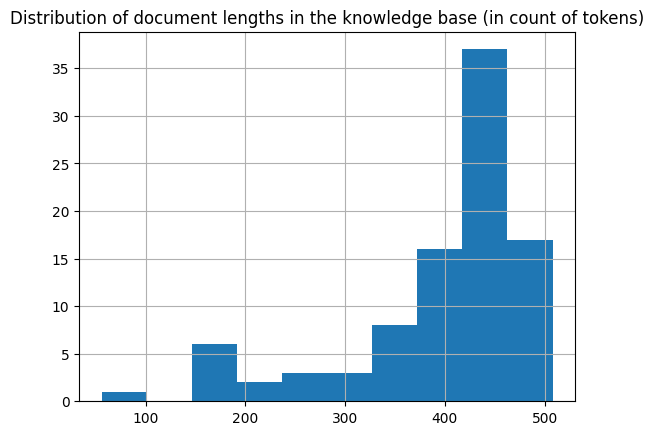

In [43]:
plot_docs_tokens(docs_processed, EMBEDDING_MODEL_NAME)

In [44]:
print(f"Number of chunks: {len(docs_processed)}")

Number of chunks: 93


In [47]:
def load_embedding_model(
    model_name = "BAAI/bge-large-en-v1.5",
    device = "cuda"
) -> HuggingFaceBgeEmbeddings:
    
    model_kwargs = {"device": device}
    encode_kwargs = {"normalize_embeddings": True}  # For cosine similarity computation

    embedding_model = HuggingFaceBgeEmbeddings(
        model_name=model_name,
        model_kwargs=model_kwargs,
        encode_kwargs=encode_kwargs,
    )
    
    return embedding_model


def embed_docs_in_chroma(docs, collection):
    
    pbar = tqdm(total=len(docs))

    for doc in docs:
        id = doc.metadata["start_index"]
        doc_text = doc.page_content
        collection.add(
            embeddings=openai_ef([doc_text])[0],
            metadatas={},
            documents=doc_text,
            ids=id
        )
        pbar.update(1)
    pbar.close()

In [48]:
embedding_model = load_embedding_model()
embedding_model.encode(["This is a test sentence."])

/home/yl3427/miniconda3/envs/llm_env/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


AttributeError: 'HuggingFaceBgeEmbeddings' object has no attribute 'encode'

In [1]:
import chromadb
client = chromadb.Client()

brca_collection = client.create_collection(name = "brca", metadata={"hnsw:space": "cosine"})
print(brca_collection)

Collection(id=557f5b31-a2e6-41f7-9a8f-6dc357cec51c, name=brca)


In [2]:
brca_collection.modify(name="brca_collection")
print(brca_collection)

Collection(id=557f5b31-a2e6-41f7-9a8f-6dc357cec51c, name=brca_collection)


In [5]:
brca_collection.metadata

{'hnsw:space': 'cosine'}

In [ ]:
# Adding raw documents
brca_collection.add(
    documents = [
        "This is a test document",
        "This is another test document"
    ],
    metadatas = [
        {"source": "source1", "language": "en"},
        {"source": "source2"}
    ],
    ids = ["id1", "id2"]
)